In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
from transformers import pipeline
from sklearn.utils.class_weight import compute_class_weight



In [2]:
#Loading the training and test data
train_path = '/content/propaganda_train.tsv'
test_path = '/content/propaganda_val.tsv'
train_df = pd.read_csv(train_path, delimiter = '\t', quotechar='|')
test_df = pd.read_csv(test_path, delimiter = '\t', quotechar='|')


##Exploratory Data Analysis

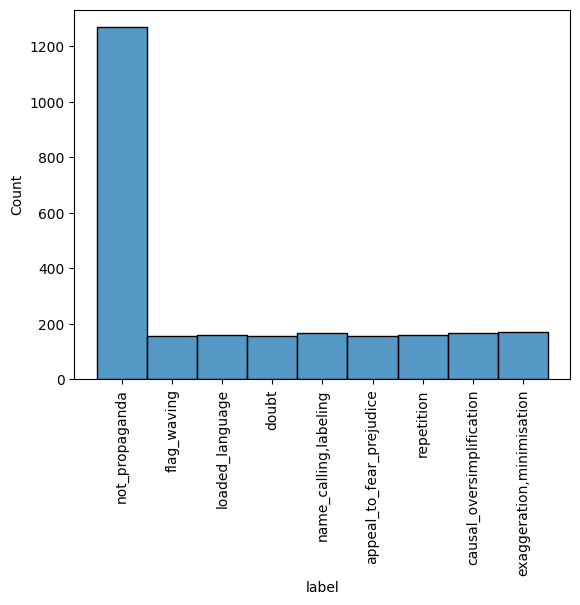

In [3]:
#Label Distribution
sns.histplot(train_df['label'])
plt.xticks(rotation = 90)
plt.show()

In [ ]:
#Average length of sentence in each label
train_df['sentence_length'] = [len(sentence.split()) for sentence in train_df.tagged_in_context]
avg_sentence_length = train_df.groupby('label')['sentence_length'].mean()
avg_sentence_length

,sentence_length
label,
appeal_to_fear_prejudice,31.171975
causal_oversimplification,34.896970
doubt,33.012739
"exaggeration,minimisation",32.705882
flag_waving,32.251613
loaded_language,29.465839
"name_calling,labeling",35.078313
not_propaganda,22.874704
repetition,26.262500


In [ ]:
#Checking Snippet Length
snippet_length = []

for sentence in train_df.tagged_in_context:
    words = sentence.split()

    if '<BOS>' in words and '<EOS>' in words:
        snippet_length.append(words.index('<EOS>') - words.index('<BOS>') - 1)
    else :
        snippet_length.append(None)

train_df['snippet_length'] = snippet_length

In [ ]:
avg_snippet_length = train_df.groupby('label')['snippet_length'].mean()
avg_snippet_length

,snippet_length
label,
appeal_to_fear_prejudice,9.566667
causal_oversimplification,17.411765
doubt,10.612903
"exaggeration,minimisation",5.118644
flag_waving,5.307692
loaded_language,2.756098
"name_calling,labeling",3.511628
not_propaganda,6.441292
repetition,2.229885


#Task 1 : Propaganda Identification

##Classical Approach : Multinomial Naive Bayes
1. Using Bag of words representation

In [26]:
#Extracting text snippets between <BOS> and <EOS>
def extract_bos_eos(text):
    start = text.find('<BOS>') + len('<BOS>')
    end = text.find('<EOS>')
    return text[start:end].strip()

train_df['span'] = train_df['tagged_in_context'].apply(extract_bos_eos)
test_df['span'] = test_df['tagged_in_context'].apply(extract_bos_eos)

In [28]:
#Using Bag of words representations on propaganda snippets
vectorizer = CountVectorizer()
vectorizer.fit(train_df.span)
train_transformed = vectorizer.transform(train_df.span)

#Training the classifier
classifier = MultinomialNB()
classifier.fit(train_transformed, train_df.label)

#Predicting and checking Accuracy
test_transformed = vectorizer.transform(test_df.span)
test_results = classifier.predict(test_transformed)

print(classification_report(test_results, test_df.label))

                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.09      0.40      0.15        10
causal_oversimplification       0.31      0.50      0.39        22
                    doubt       0.05      0.15      0.07        13
exaggeration,minimisation       0.13      0.67      0.22         6
              flag_waving       0.33      0.83      0.48        18
          loaded_language       0.00      0.00      0.00         1
    name_calling,labeling       0.03      0.33      0.05         3
           not_propaganda       0.97      0.57      0.72       562
               repetition       0.07      0.60      0.13         5

                 accuracy                           0.56       640
                macro avg       0.22      0.45      0.25       640
             weighted avg       0.88      0.56      0.67       640



In [29]:
#Using Bag of words representations on entire texts
vectorizer.fit(train_df.tagged_in_context)
train_transformed = vectorizer.transform(train_df.tagged_in_context)

classifier.fit(train_transformed, train_df.label)

test_transformed = vectorizer.transform(test_df.tagged_in_context)
test_results = classifier.predict(test_transformed)

print(classification_report(test_results, test_df.label))

                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.02      0.17      0.04         6
causal_oversimplification       0.03      0.50      0.05         2
                    doubt       0.02      0.50      0.04         2
exaggeration,minimisation       0.03      0.14      0.05         7
              flag_waving       0.13      0.67      0.22         9
          loaded_language       0.00      0.00      0.00         5
    name_calling,labeling       0.03      0.33      0.05         3
           not_propaganda       0.99      0.55      0.70       599
               repetition       0.07      0.43      0.13         7

                 accuracy                           0.53       640
                macro avg       0.15      0.36      0.14       640
             weighted avg       0.93      0.53      0.66       640



2. Using Tf-Idf representation

In [31]:
#Using tf-Idf representations on propaganda snippets
vectorizer = TfidfVectorizer()
vectorizer.fit(train_df.span)
train_transformed = vectorizer.transform(train_df.span)

#Training the classifier
classifier = MultinomialNB()
classifier.fit(train_transformed, train_df.label)

#Predicting and checking Accuracy
test_transformed = vectorizer.transform(test_df.span)
test_results = classifier.predict(test_transformed)

print(classification_report(test_results, test_df.label))

                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.00      0.00      0.00         0
causal_oversimplification       0.00      0.00      0.00         0
                    doubt       0.00      0.00      0.00         0
exaggeration,minimisation       0.00      0.00      0.00         0
              flag_waving       0.07      1.00      0.12         3
          loaded_language       0.00      0.00      0.00         0
    name_calling,labeling       0.00      0.00      0.00         0
           not_propaganda       1.00      0.52      0.68       637
               repetition       0.00      0.00      0.00         0

                 accuracy                           0.52       640
                macro avg       0.12      0.17      0.09       640
             weighted avg       1.00      0.52      0.68       640



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
#Using tTf-Idf representations on entire texts
vectorizer.fit(train_df.tagged_in_context)
train_transformed = vectorizer.transform(train_df.tagged_in_context)

classifier.fit(train_transformed, train_df.label)

test_transformed = vectorizer.transform(test_df.tagged_in_context)
test_results = classifier.predict(test_transformed)

print(classification_report(test_results, test_df.label))

                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.00      0.00      0.00         0
causal_oversimplification       0.00      0.00      0.00         0
                    doubt       0.00      0.00      0.00         0
exaggeration,minimisation       0.00      0.00      0.00         0
              flag_waving       0.00      0.00      0.00         0
          loaded_language       0.00      0.00      0.00         0
    name_calling,labeling       0.00      0.00      0.00         0
           not_propaganda       1.00      0.52      0.68       640
               repetition       0.00      0.00      0.00         0

                 accuracy                           0.52       640
                macro avg       0.11      0.06      0.08       640
             weighted avg       1.00      0.52      0.68       640



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##Deep Learning Approach : Fine-tuning BERT

In [33]:
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [34]:
labellist=sorted(list(set(train_df['label'].unique()).union(set(test_df['label'].unique()))))

labels={label:i for i,label in enumerate(labellist)}
labels

{'appeal_to_fear_prejudice': 0,
 'causal_oversimplification': 1,
 'doubt': 2,
 'exaggeration,minimisation': 3,
 'flag_waving': 4,
 'loaded_language': 5,
 'name_calling,labeling': 6,
 'not_propaganda': 7,
 'repetition': 8}

In [42]:
#Custom PyTorch dataset for tokenization
class Dataset(torch.utils.data.Dataset):

    def __init__(self,df,column='tagged_in_context'):
        self.labels=[labels[label] for label in df['label']]
        self.texts=[tokenizer(text.lower(),padding='max_length',max_length=512,truncation=True,return_tensors="pt") for text in df[column]]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self,idx):
        return self.texts[idx]

    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)

        return batch_texts,batch_y


train_data=Dataset(train_df)
test_data=Dataset(test_df)

In [43]:
#Preparing input tensors for GPU
def prepare_inputs(input1,label,device):
  label=label.to(device)
  mask=input1['attention_mask'].to(device)
  input_id=input1['input_ids'].squeeze(1).to(device)
  return (input_id,mask,label)

In [44]:
#Checking if GPU is available
use_cuda=torch.cuda.is_available()
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.")
device=torch.device("cuda" if use_cuda else "cpu")

GPU acceleration enabled


In [45]:
#Creating the BERT classifier
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1, num_classes=9):
        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(768, 256)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(256, num_classes)


    def forward(self, input_id, mask):
        hidden_output, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)

        hidden_output = self.hidden(dropout_output)
        relu_output = self.relu(hidden_output)
        final_output = self.classifier(relu_output)

        return final_output


In [46]:
#Assigning weights to imbalanced classes

class_ids = np.array(list(labels.values()))

y_train = train_df['label'].map(labels).values

weights = compute_class_weight(class_weight='balanced', classes=class_ids, y=y_train)
weights = torch.tensor(weights, dtype=torch.float).to(device)

In [47]:
#Training Loop
def train(model, train_data,val_data,learning_rate,epochs):

    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=2,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(test_data,batch_size=2)

    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")

    criterion=nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=learning_rate)

    if use_cuda:
        model=model.cuda()
        criterion=criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train=0
        total_loss_train=0
        model.train()
        for train_input,train_label in tqdm(train_dataloader):

            input_id,mask, train_label=prepare_inputs(train_input,train_label,device)

            output=model(input_id,mask)
            #print(f"Output : {output}")
            #print(f"Train Label : {train_label.long()}")
            batch_loss=criterion(output,train_label.long())
            total_loss_train +=batch_loss.item()

            acc=(output.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val=0
        total_loss_val=0
        model.eval()
        with torch.no_grad():
            for val_input,val_label in val_dataloader:

                input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                output=model(input_id,mask)

                batch_loss=criterion(output,val_label.long())

                total_loss_val+=batch_loss.item()

                acc=(output.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc

        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')


In [48]:
#Specifying parameters
EPOCHS=5
model=BertClassifier(num_classes=len(labels.keys()))
LR=1e-5
model.bert.requires_grad_(False)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [49]:
train(model,train_data,test_data,LR,EPOCHS)

100%|██████████| 1280/1280 [01:14<00:00, 17.16it/s]


Epochs: 1 | Train Loss: 0.902 | Train Accuracy: 0.480
Val loss: 0.853 | Val Accuracy: 0.517


100%|██████████| 1280/1280 [01:17<00:00, 16.54it/s]


Epochs: 2 | Train Loss: 0.869 | Train Accuracy: 0.495
Val loss: 0.851 | Val Accuracy: 0.517


100%|██████████| 1280/1280 [01:17<00:00, 16.44it/s]


Epochs: 3 | Train Loss: 0.863 | Train Accuracy: 0.496
Val loss: 0.844 | Val Accuracy: 0.517


100%|██████████| 1280/1280 [01:18<00:00, 16.24it/s]


Epochs: 4 | Train Loss: 0.860 | Train Accuracy: 0.496
Val loss: 0.839 | Val Accuracy: 0.517


100%|██████████| 1280/1280 [01:19<00:00, 16.11it/s]


Epochs: 5 | Train Loss: 0.855 | Train Accuracy: 0.496
Val loss: 0.836 | Val Accuracy: 0.517


In [66]:
#Evaluation
batchsize=2
def evaluate(model,test_dataset):
    model.eval()
    test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batchsize)

    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model=model.cuda()

    total_acc_test=0
    true_labels = []

    with torch.no_grad():
        count=0
        predictions=[]
        for test_input,test_label in tqdm(test_dataloader):
            count+=batchsize
            test_label=test_label.to(device)
            mask=test_input['attention_mask'].to(device)
            input_id=test_input['input_ids'].squeeze(1).to(device)
            output=model(input_id,mask)
            preds = output.argmax(dim=1)
            #print(output.argmax(dim=1),test_label)
            #predictions.append(output.argmax(dim=1))  #save the prediction for further analysis
            predictions.extend(preds.detach().cpu().numpy().tolist())
            true_labels.extend(test_label.detach().cpu().numpy().tolist())
            acc=(output.argmax(dim=1)==test_label).sum().item()

            total_acc_test+=acc
            if count%100==0:
                print(f'Accuracy so far = {total_acc_test/count: .3f}')
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions))

    print(f'Test accuracy: {total_acc_test/len(test_dataset): .3f}')
    return predictions

In [67]:
predictions=evaluate(model, test_data)

 16%|█▋        | 52/320 [00:02<00:14, 18.59it/s]

Accuracy so far =  0.500


 32%|███▏      | 102/320 [00:05<00:11, 18.55it/s]

Accuracy so far =  0.510


 48%|████▊     | 152/320 [00:08<00:09, 18.31it/s]

Accuracy so far =  0.523


 63%|██████▎   | 202/320 [00:11<00:06, 18.42it/s]

Accuracy so far =  0.517


 79%|███████▉  | 252/320 [00:13<00:03, 18.34it/s]

Accuracy so far =  0.506


 94%|█████████▍| 302/320 [00:16<00:00, 18.38it/s]

Accuracy so far =  0.517


100%|██████████| 320/320 [00:17<00:00, 18.33it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00        43
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        45
           5       0.00      0.00      0.00        39
           6       0.00      0.00      0.00        34
           7       0.52      1.00      0.68       331
           8       0.00      0.00      0.00        40

    accuracy                           0.52       640
   macro avg       0.06      0.11      0.08       640
weighted avg       0.27      0.52      0.35       640

Test accuracy:  0.517



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Task 2 : Span Identification and Technique Identification

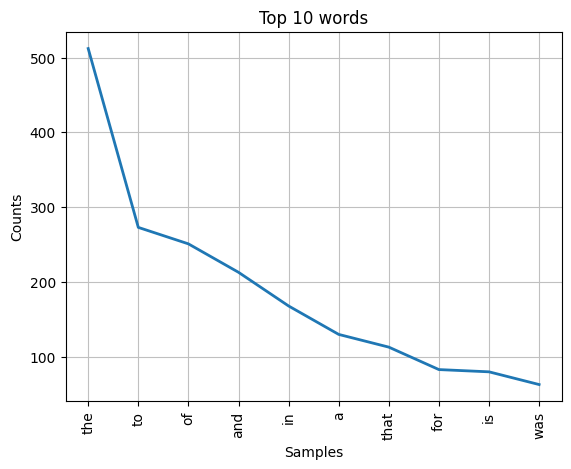

In [68]:
words = [word for _, rows in train_df.iterrows() if rows.label == 'not_propaganda' for word in rows.span.split()]
fdist = FreqDist(words)

fdist.plot(10, title = 'Top 10 words')
plt.show()

In [69]:
#Approach 1 : Build a naive bayes binary classifier and then do the span detector (using CountVectorizer)

#converting labels in to binary
train_df['labels'] = train_df['label'].apply(lambda x:x if x == 'not_propaganda' else 'propaganda')
test_df['labels'] = test_df['label'].apply(lambda x:x if x== 'not_propaganda' else 'propaganda')

#vectorizing the text
vectorizer = CountVectorizer()
train_transform = vectorizer.fit_transform(train_df.tagged_in_context)
test_transform = vectorizer.transform(test_df.tagged_in_context)

#naive bayes model
classifier = MultinomialNB()
classifier.fit(train_transform, train_df.labels)



MultinomialNB()

In [80]:
#Approach 2 : Build a naive bayes binary classifier and then do the span detector (using TfidfVectorizer)

#converting labels in to binary
train_df['labels'] = train_df['label'].apply(lambda x:x if x == 'not_propaganda' else 'propaganda')
test_df['labels'] = test_df['label'].apply(lambda x:x if x== 'not_propaganda' else 'propaganda')

#vectorizing the text
vectorizer = TfidfVectorizer()
train_transform = vectorizer.fit_transform(train_df.tagged_in_context)
test_transform = vectorizer.transform(test_df.tagged_in_context)

#naive bayes model
classifier = MultinomialNB()
classifier.fit(train_transform, train_df.labels)



MultinomialNB()

In [81]:
test_results = classifier.predict(test_transform)
print(classification_report(test_df.labels, test_results))


                precision    recall  f1-score   support

not_propaganda       0.83      0.52      0.64       331
    propaganda       0.63      0.88      0.74       309

      accuracy                           0.70       640
     macro avg       0.73      0.70      0.69       640
  weighted avg       0.73      0.70      0.69       640



In [82]:
#Removing not_propaganda and proceeding with propaganda texts only
train_df_v2 = train_df[train_df.labels == 'propaganda']


In [83]:
# Prepare BIO data
def get_bio_labels(text, label, tokenizer):
    if '<BOS>' in text and '<EOS>' in text:
        pre, rest = text.split('<BOS>')
        span, post = rest.split('<EOS>')
        clean_text = pre.strip() + ' ' + span.strip() + ' ' + post.strip()
        tokens = tokenizer.tokenize(clean_text)
        span_tokens = tokenizer.tokenize(span.strip())
        span_start = len(tokenizer.tokenize(pre.strip()))
        span_len = len(span_tokens)
        bio_labels = ['O'] * len(tokens)
        if span_len > 0:
            bio_labels[span_start] = 'B-' + label
            for i in range(1, span_len):
                bio_labels[span_start + i] = 'I-' + label
        return tokens, bio_labels
    else:
        clean_text = text.replace('<BOS>', '').replace('<EOS>', '').strip()
        tokens = tokenizer.tokenize(clean_text)
        bio_labels = ['O'] * len(tokens)
        return tokens, bio_labels

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


# Filter out 'not_propaganda' samples during BIO label generation
train_bio = []
for _, row in train_df_v2.iterrows():
    if row['label'] == 'not_propaganda':
        continue
    bio_data = get_bio_labels(row['tagged_in_context'], row['label'], tokenizer)
    train_bio.append(bio_data)

test_bio = []
for _, row in test_df.iterrows():
    if row['label'] == 'not_propaganda':
        continue
    bio_data = get_bio_labels(row['tagged_in_context'], row['label'], tokenizer)
    test_bio.append(bio_data)


In [84]:
# Build label2id and id2label
all_labels = set(l for _, labels in train_bio for l in labels)
label_list = sorted(all_labels)
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}

# Encode examples with proper subword alignment
def encode_examples(bio_data, tokenizer, label2id, max_length=128):
    input_ids, attention_masks, label_ids = [], [], []
    for tokens, labels in bio_data:
        enc = tokenizer(tokens, truncation=True, padding='max_length', max_length=max_length, is_split_into_words=True, return_tensors='pt')
        word_ids = enc.word_ids(batch_index=0)
        label_id = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_id.append(-100)
            elif word_idx != previous_word_idx:
                label_id.append(label2id[labels[word_idx]])
            else:
                # For subword tokens, use I- label if B-, else same
                if labels[word_idx].startswith('B-'):
                    label_id.append(label2id[labels[word_idx].replace('B-', 'I-')])
                else:
                    label_id.append(label2id[labels[word_idx]])
            previous_word_idx = word_idx
        label_id = label_id[:max_length] + [label2id['O']] * (max_length - len(label_id))
        input_ids.append(enc['input_ids'][0])
        attention_masks.append(enc['attention_mask'][0])
        label_ids.append(label_id)
    return {
        'input_ids': torch.stack(input_ids),
        'attention_mask': torch.stack(attention_masks),
        'labels': torch.tensor(label_ids)
    }

train_enc = encode_examples(train_bio, tokenizer, label2id)
test_enc = encode_examples(test_bio, tokenizer, label2id)

class PropagandaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.encodings.items()}
    def __len__(self):
        return self.encodings['input_ids'].shape[0]

train_dataset = PropagandaDataset(train_enc)
test_dataset = PropagandaDataset(test_enc)

In [85]:
#Initializing the BERT model and training
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(label2id), id2label=id2label, label2id=label2id)

#defining the hyper parameters for training
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

#Initializing the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

trainer.train()
results = trainer.evaluate()
print("BERT Token Classification Evaluation:", results)

# Predict on test set
predictions, labels, _ = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions, axis=2)

# Convert IDs back to labels
pred_label_names = [[id2label[id] if id != -100 else 'O' for id in sent] for sent in pred_labels]


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-85-5504cea2dd75>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.240000,1.329305
2,1.160700,1.258251
3,0.764800,1.268886
4,0.614800,1.464303
5,0.326600,1.486336


BERT Token Classification Evaluation: {'eval_loss': 1.4863356351852417, 'eval_runtime': 2.0858, 'eval_samples_per_second': 148.145, 'eval_steps_per_second': 18.698, 'epoch': 5.0}


In [86]:
#Converting BIO encoding back to span
def get_main_span_and_technique(tokens, labels):
    # Find all spans (ignore 'O' and 'not_propaganda')
    spans = []
    current_span = []
    current_label = None
    for token, label in zip(tokens, labels):
        if label.startswith('B-'):
            if current_span:
                spans.append((current_span, current_label))
            current_span = [token]
            current_label = label[2:]
        elif label.startswith('I-') and current_span and label[2:] == current_label:
            current_span.append(token)
        else:
            if current_span:
                spans.append((current_span, current_label))
                current_span = []
                current_label = None
    if current_span:
        spans.append((current_span, current_label))

    # Remove not_propaganda spans
    spans = [s for s in spans if s[1] != 'not_propaganda']

    if not spans:
        # No propaganda span found
        return None, 'not_propaganda'
    else:
        # Pick the longest span (if tie, pick the first)
        main_span, main_label = max(spans, key=lambda x: len(x[0]))
        return ' '.join(main_span), main_label


In [87]:
#Adding the technique prediction for further classification
test_df['predicted_results'] = test_results

In [88]:
#Creating a pipeline to run through the entire architecture in a convenient manner

# Create the NER pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

y_true = []
y_pred = []

test_df_v2 = test_df[test_df.predicted_results == 'propaganda']

for idx, row in test_df_v2.iterrows():
    sentence = row['tagged_in_context'] #.replace('<BOS>', '').replace('<EOS>', '')
    true_label = row['label']
    y_true.append(true_label)

    ner_results = ner_pipeline(sentence)
    # Get all predicted techniques (entity_group)
    techniques = [entity['entity_group'] for entity in ner_results if entity['entity_group'] != 'not_propaganda']
    if techniques:
        # If multiple, pick the most common (or just the first)
        pred_label = max(set(techniques), key=techniques.count)
    else:
        pred_label = 'not_propaganda'
    y_pred.append(pred_label)

    pred_span_tokens = [ent['word'] for ent in ner_results if ent['entity_group'] != 'not_propaganda']
    pred_span = ' '.join(pred_span_tokens).replace(" ##", "")  # Remove BERT's subword markers

    print(f"Sentence: {sentence}")
    print(f"Original span : {true_label}")
    print(f"Predicted span : {pred_span}")
    print(f"Predicted: {pred_label} | True: {true_label}")
    print()

# Calculate accuracy
print(classification_report(y_true, y_pred))


Device set to use cuda:0


Sentence: Mostly because <BOS> the country would not last long without an outside high IQ elite to run the country <EOS>. 
Original span : causal_oversimplification
Predicted span : the country would not last long without an iq elite to run the country < eos
Predicted: flag_waving | True: causal_oversimplification

Sentence: Lyndon Johnson <BOS> gets Earl Warren and Sen. Richard Russel to join the Warren Commission by telling them that the assassination could lead to World War III <EOS>. 
Original span : appeal_to_fear_prejudice
Predicted span : the assassination could lead to world war iii < eos
Predicted: appeal_to_fear_prejudice | True: appeal_to_fear_prejudice

Sentence: It must be exacted from him directly in order to vilify and humiliate him, so that Islam and its people may be exalted and the race of <BOS> infidels <EOS> brought low. 
Original span : repetition
Predicted span : islam and its people exalted race bofide
Predicted: appeal_to_fear_prejudice | True: repetition

Sente